## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import os

## Importing Dataset

In [4]:
train_data = pd.read_csv("train.csv")

## Text Analysis

In [5]:
train_data.head().style.background_gradient(cmap="coolwarm")

,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
train_data.shape

(7613, 5)

## Heat Map

<AxesSubplot:>

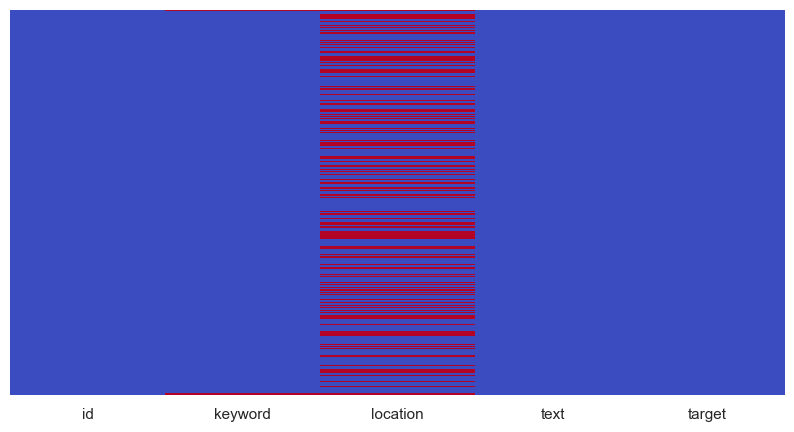

In [7]:
sns.set(rc={"figure.figsize":(10,5)})
sns.heatmap(train_data.isnull(), yticklabels=False,cbar=False,cmap="coolwarm")

## Analysis and Visualization of Target

In [8]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Distribution')

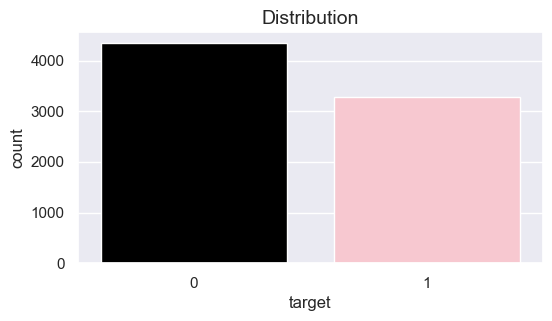

In [9]:
plt.figure(figsize=(6,3))
colors = ["black","pink"]
sns.countplot(x='target', data=train_data, palette=colors)
plt.title('Distribution',fontsize =14)

## Analysis and Visualization of Features

### KEYWORD

In [10]:
train_data['keyword'].nunique()

221

#### Plotting top 20 keywords

Text(0.5, 0, 'Count of Keywords')

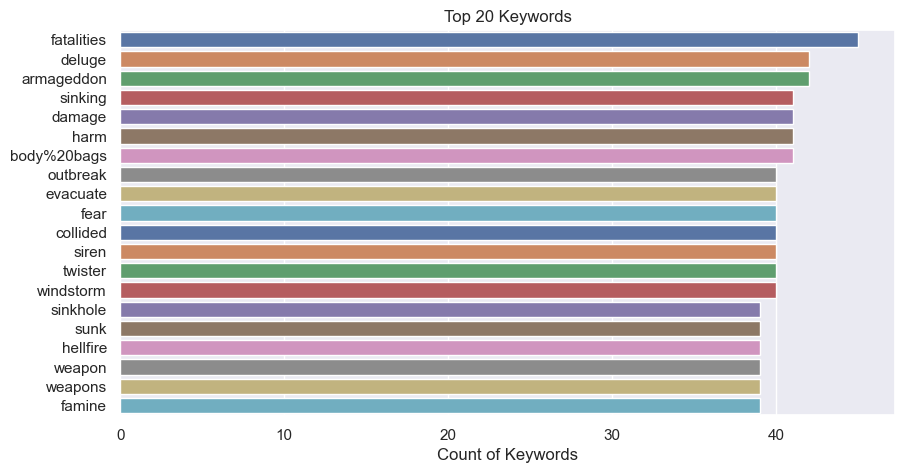

In [11]:
chains=train_data['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title('Top 20 Keywords')
plt.xlabel('Count of Keywords')

#### Plotting top 20 disaster and non disaster keywords

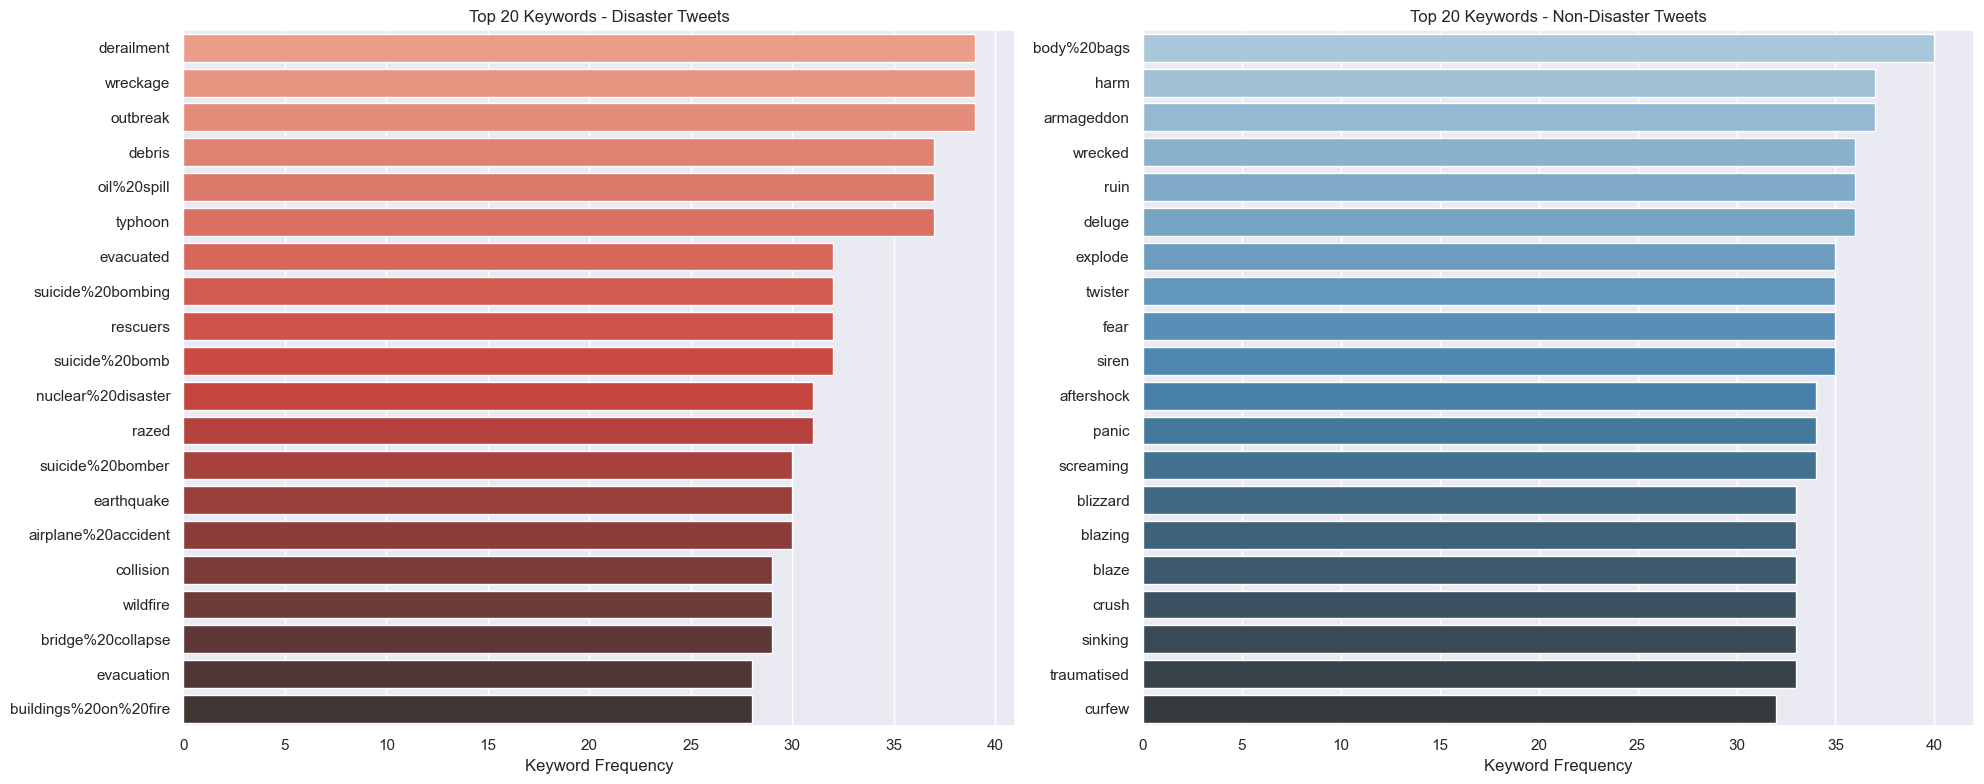

In [12]:
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

#### Plotting highest usage disaster keyword and lowest usage disaster keyword

In [13]:
top_disaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values(ascending = False).head(20)
top_nondisaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values().head(20)

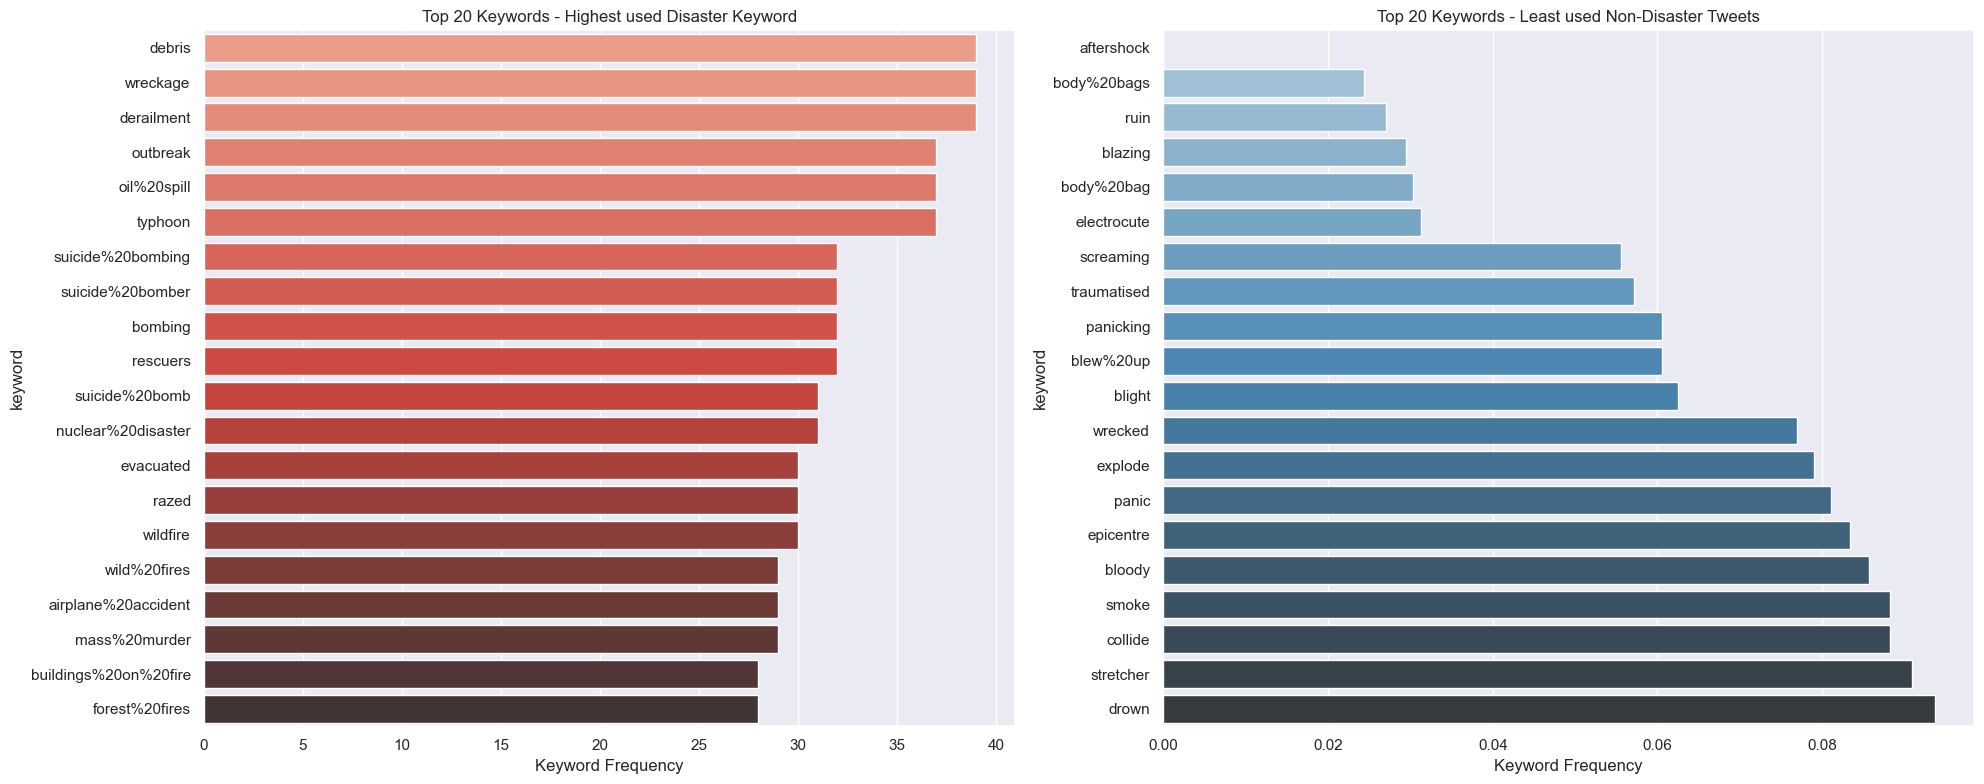

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

sns.barplot(y=top_disaster_keyword[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Highest used Disaster Keyword")
ax[0].set_xlabel("Keyword Frequency")


sns.barplot(y=top_nondisaster_keyword[0:20].index, x=top_nondisaster_keyword[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Least used Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

### LOCATION

In [15]:
locations = train_data["location"].value_counts()

#### Plotting top 20 locations of tweets

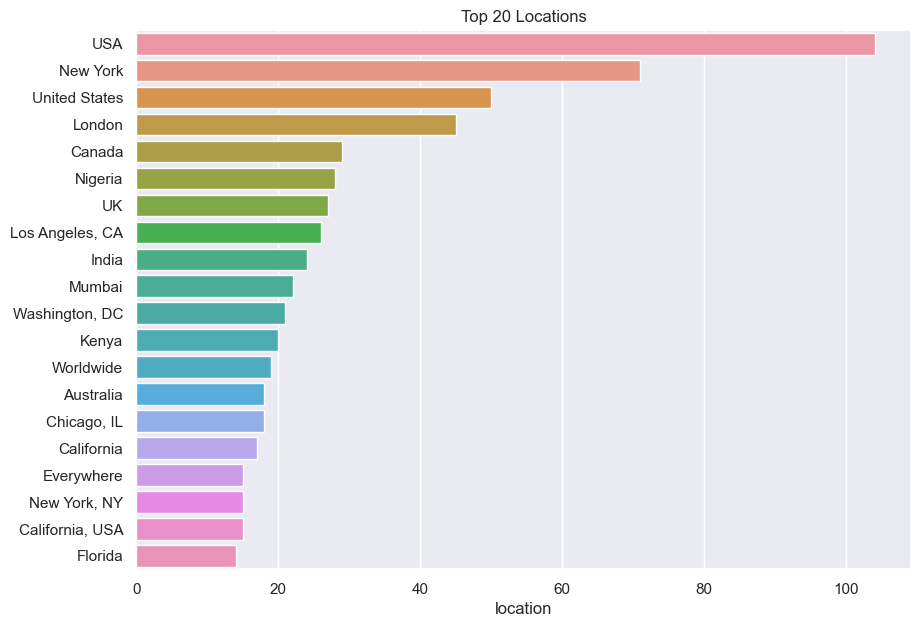

In [16]:
plt.figure(figsize=(10,7))


sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')

plt.title("Top 20 Locations")
plt.show()

### TEXT

In [17]:
print(len(train_data['text']))

7613


In [18]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [19]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [20]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [21]:
train_data[train_data['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

#### Plotting tweets length

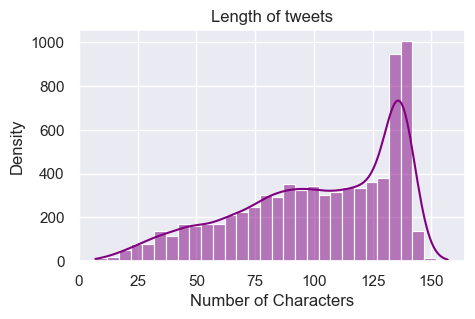

In [22]:
plt.figure(figsize=(5,3))
sns.histplot(train_data["length"], kde=True,color='purple',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

#### Plotting tweets length wrt target

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

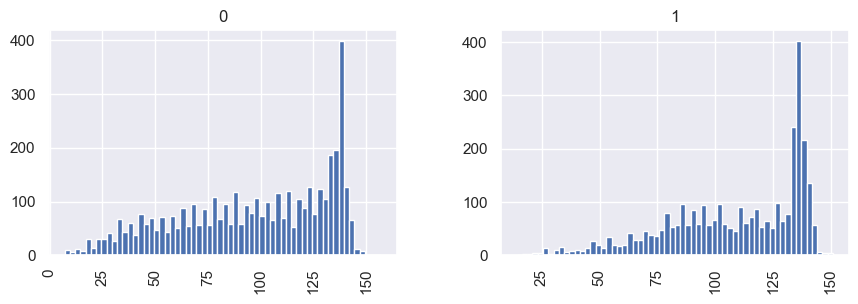

In [23]:
train_data.hist(column='length', by = 'target',bins =60, figsize= (10,3))

#### Plotting number of words in tweets

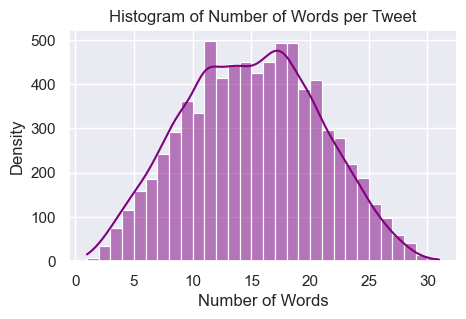

In [24]:
def count_words(x):
    return len(x.split())

train_data["num_words"] = train_data["text"].apply(count_words)

plt.figure(figsize=(5,3))
sns.histplot(train_data["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

#### Plotting number of words in tweets wrt target

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

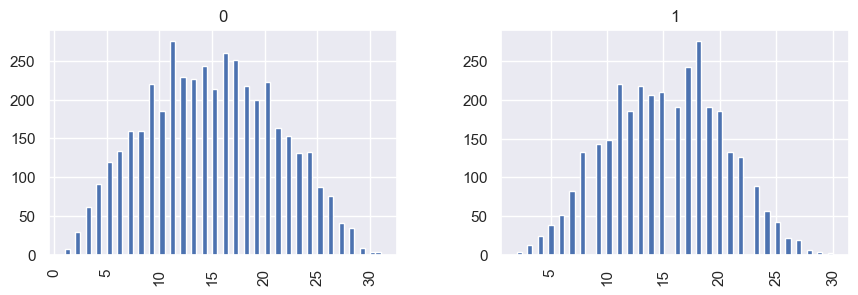

In [25]:
train_data.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

Text Preprocessing

Removing Punctuations

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def toclean_text(text):


    clean_text = [char for char in text if char not in string.punctuation]

    clean_text = ''.join(clean_text)


    return clean_text

In [28]:
train_data['clean_text'] = train_data['text'].apply(toclean_text)

In [29]:
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


Removing Noise

In [30]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
     "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
     "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [31]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [32]:
def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # replace abbreviations, @ and number
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    return text

In [33]:
train_data["clean_text"] = train_data["clean_text"].apply(clean_tweet)

In [34]:
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


Removing Stopwords

In [35]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [36]:
def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return remove_stopword

In [37]:
train_data['clean_text'] = train_data['clean_text'].apply(toremove_stopword)

In [38]:
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,"[NUMBER, people, receive, wildfires, evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


Tokenization

In [39]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)

In [40]:
X.shape

(7613, 20)

In [41]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  713,  154,   56, 1434,   14])

In [42]:
tokenizer.sequences_to_texts([[ 713,  154,   56, 1434,   14]])

['reason earthquake may allah us']

# Model creation Using LSTM

Splitting Text data

In [43]:
y = train_data['target']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

Long Short Term Memory - LSTM

In [45]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [46]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104353 (407.63 KB)
Trainable params: 104353 (407.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [47]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 9s 23ms/step - loss: 0.5425 - accuracy: 0.7245 - val_loss: 0.4323 - val_accuracy: 0.8155
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3770 - accuracy: 0.8366 - val_loss: 0.4429 - val_accuracy: 0.8129
Epoch 3/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3254 - accuracy: 0.8603 - val_loss: 0.4620 - val_accuracy: 0.7991
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2896 - accuracy: 0.8808 - val_loss: 0.5276 - val_accuracy: 0.7879
Epoch 5/10
191/191 [==============================] - 4s 20ms/step - loss: 0.2633 - accuracy: 0.8938 - val_loss: 0.5397 - val_accuracy: 0.7820
Epoch 6/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2354 - accuracy: 0.9038 - val_loss: 0.6269 - val_accuracy: 0.7774
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2083 - accuracy: 0.9161 - val_loss: 0.6612 - val_accuracy: 0.7761

In [48]:
y_pred = model.predict(X_test).round()

48/48 [==============================] - 1s 6ms/step


In [49]:
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

# Evaluation

In [50]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

191/191 [==============================] - 1s 5ms/step


96

In [51]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7524622455679579
Recall  is    :  0.7408536585365854
Precision  is :  0.7012987012987013


Confusion Matrix

In [52]:
conm = confusion_matrix(y_test,y_pred)
conm

array([[660, 207],
       [170, 486]], dtype=int64)

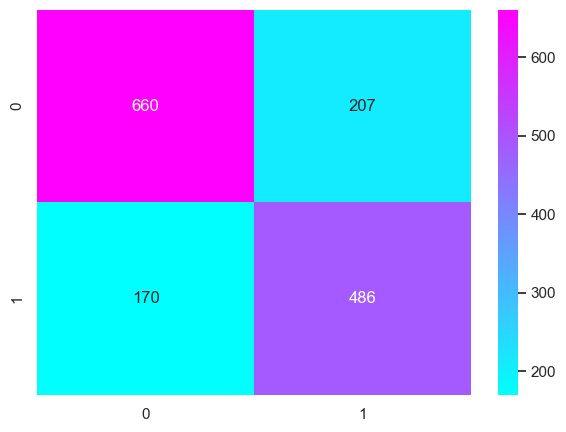

In [53]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

Classification Report

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       867
           1       0.70      0.74      0.72       656

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



In [55]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

In [56]:
#calculate Matthews correlation coefficient
matthews_corrcoef(y_test, y_pred)

0.49928147158863895

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc = roc_auc_score(y_test, y_pred)
print('ROC: %.3f' % roc)

ROC: 0.751
